In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import random
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.15.1
GPU Available: []


In [3]:
# Configuration parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
EMBEDDING_DIM = 64
EPOCHS = 50
LEARNING_RATE = 1e-5

# Dataset paths
DATASET_ROOT = './notebook/breed_organized_with_images'
TRAIN_CSV = os.path.join(DATASET_ROOT, 'all_train_info.csv')
VAL_CSV = os.path.join(DATASET_ROOT, 'all_val_info.csv')
TEST_CSV = os.path.join(DATASET_ROOT, 'all_test_info.csv')

# Model save paths
MODEL_DIR = './models'
os.makedirs(MODEL_DIR, exist_ok=True)

print("Configuration loaded successfully!")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")


Configuration loaded successfully!
Image size: 224x224x3
Batch size: 32
Epochs: 50
Learning rate: 1e-05


Dataset Statistics:
Training samples: 4405
Validation samples: 1480
Test samples: 1464
Total samples: 7349

Breed distribution in training set:
breed_name
yorkshire_terrier     120
basset_hound          120
pug                   120
pomeranian            120
miniature_pinscher    120
leonberger            120
japanese_chin         120
havanese              120
great_pyrenees        120
german_shorthaired    120
Name: count, dtype: int64


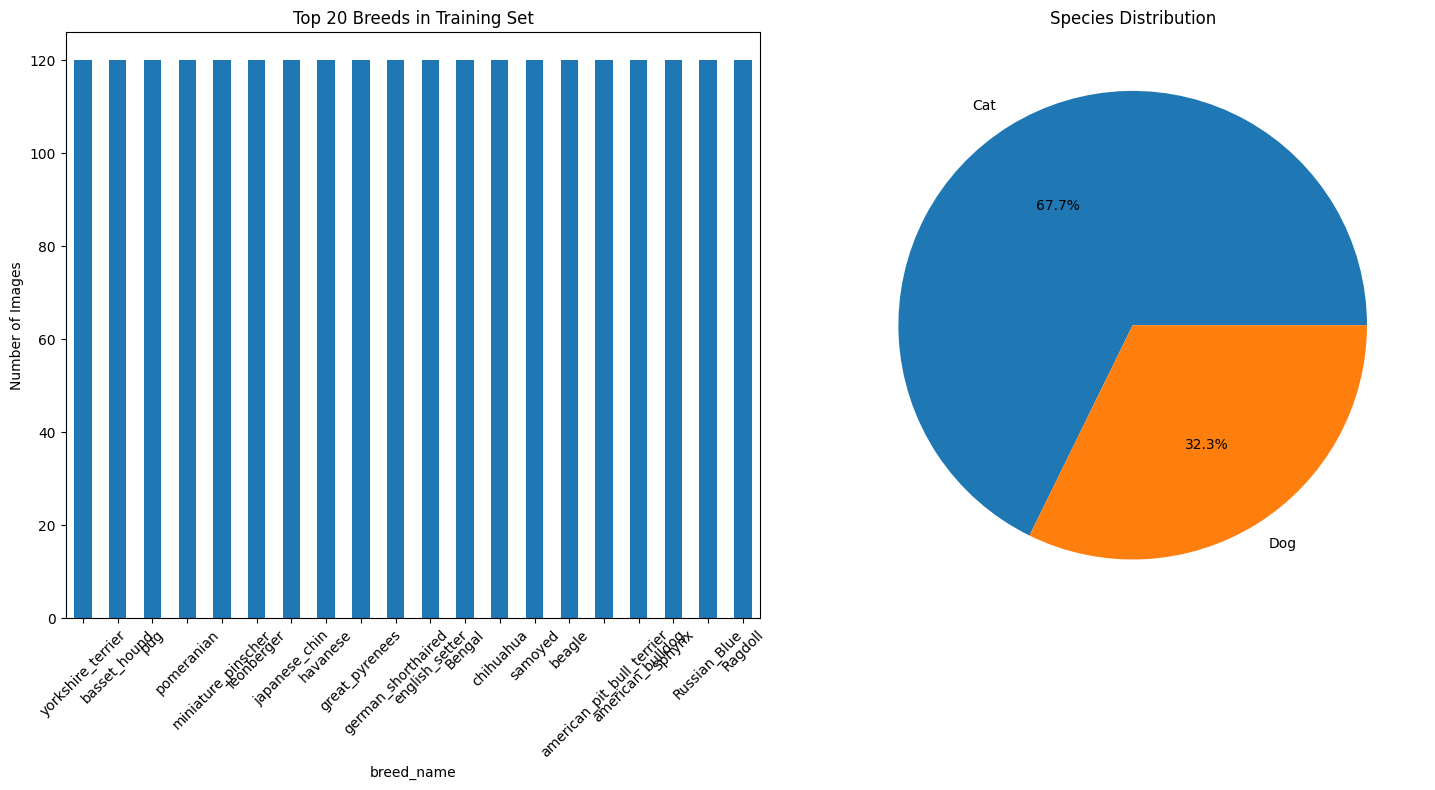

In [4]:
# Load and explore the dataset
def load_dataset_info():
    """Load the CSV files containing dataset information"""
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(VAL_CSV)
    test_df = pd.read_csv(TEST_CSV)
    
    print("Dataset Statistics:")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"Total samples: {len(train_df) + len(val_df) + len(test_df)}")
    
    # Check class distribution
    print("\nBreed distribution in training set:")
    breed_counts = train_df['breed_name'].value_counts()
    print(breed_counts.head(10))
    
    return train_df, val_df, test_df

train_df, val_df, test_df = load_dataset_info()

# Visualize breed distribution
plt.figure(figsize=(15, 8))
breed_counts = train_df['breed_name'].value_counts()
plt.subplot(1, 2, 1)
breed_counts.head(20).plot(kind='bar')
plt.title('Top 20 Breeds in Training Set')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')

plt.subplot(1, 2, 2)
species_counts = train_df['species'].value_counts()
species_labels = ['Cat', 'Dog']
plt.pie(species_counts.values, labels=species_labels, autopct='%1.1f%%')
plt.title('Species Distribution')

plt.tight_layout()
plt.show()


In [5]:
# Data preprocessing and pair generation functions
def load_and_preprocess_image(image_path):
    """Load and preprocess an image"""
    try:
        img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize to [0, 1]
        
        # ImageNet normalization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_array = (img_array - mean) / std
        
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def create_identity_groups(df, dataset_type):
    """Create groups of images for each individual animal identity"""
    identity_groups = {}
    
    for _, row in df.iterrows():
        filename = row['filename']
        breed_name = row['breed_name']
        
        # Create artificial identity groups based on image index within breed
        # Group every 3 images as one identity for better pair generation
        breed_images = df[df['breed_name'] == breed_name]
        img_index = breed_images.index.get_loc(row.name)
        identity_id = f"{breed_name}_id_{img_index // 3}"
        
        image_path = os.path.join(DATASET_ROOT, breed_name, dataset_type, f"{filename}.jpg")
        
        if identity_id not in identity_groups:
            identity_groups[identity_id] = []
        identity_groups[identity_id].append(image_path)
    
    # Filter groups with at least 2 images
    valid_groups = {k: v for k, v in identity_groups.items() if len(v) >= 2}
    print(f"{dataset_type} - Valid identity groups: {len(valid_groups)}")
    
    return valid_groups

# Create identity groups for all datasets
train_identities = create_identity_groups(train_df, 'train')
val_identities = create_identity_groups(val_df, 'val')
test_identities = create_identity_groups(test_df, 'test')


train - Valid identity groups: 1470
val - Valid identity groups: 486
test - Valid identity groups: 479


In [6]:
# Pair generation for Siamese network training
def generate_pairs(identity_groups, num_pairs):
    """Generate pairs of images for Siamese Network training"""
    pairs = []
    labels = []
    
    all_identities = list(identity_groups.keys())
    valid_identities = [identity for identity in all_identities 
                       if len(identity_groups[identity]) >= 2]
    
    if not valid_identities:
        raise ValueError("No valid identities with multiple images found")
    
    # Generate positive pairs (same identity)
    for _ in range(num_pairs // 2):
        identity = random.choice(valid_identities)
        images = identity_groups[identity]
        img1, img2 = random.sample(images, 2)
        pairs.append((img1, img2))
        labels.append(1)  # Same identity
    
    # Generate negative pairs (different identity)
    for _ in range(num_pairs // 2):
        identity1, identity2 = random.sample(valid_identities, 2)
        img1 = random.choice(identity_groups[identity1])
        img2 = random.choice(identity_groups[identity2])
        pairs.append((img1, img2))
        labels.append(0)  # Different identity
    
    # Shuffle pairs
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs, labels = zip(*combined)
    
    return list(pairs), list(labels)

def batch_generator(identity_groups, batch_size=32, augment=True):
    """Generator that yields batches of image pairs"""
    while True:
        pairs, labels = generate_pairs(identity_groups, batch_size)
        
        left_images = []
        right_images = []
        
        for (img1_path, img2_path), label in zip(pairs, labels):
            img1 = load_and_preprocess_image(img1_path)
            img2 = load_and_preprocess_image(img2_path)
            
            if img1 is not None and img2 is not None:
                left_images.append(img1)
                right_images.append(img2)
        
        if len(left_images) > 0:
            yield ([np.array(left_images), np.array(right_images)], np.array(labels[:len(left_images)]))

print("Pair generation functions defined successfully!")


Pair generation functions defined successfully!


In [7]:
# Model architecture definitions
def euclidean_distance(vectors):
    """Calculate the Euclidean distance between two vectors"""
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, 1e-7))

def contrastive_loss(y_true, y_pred):
    """Contrastive loss function for Siamese networks"""
    y_true = tf.cast(y_true, dtype=tf.float32)
    margin = 0.2
    y_pred = tf.maximum(y_pred, 1e-7)
    y_pred_norm = y_pred / tf.reduce_mean(y_pred)
    
    similar_loss = y_true * tf.square(y_pred_norm)
    dissimilar_loss = (1.0 - y_true) * tf.square(tf.maximum(margin - y_pred_norm, 0.0))
    
    loss = tf.reduce_mean(similar_loss + dissimilar_loss)
    return 0.1 * loss

def create_base_network(input_shape=(224, 224, 3)):
    """Create the base feature extraction network"""
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze early layers, fine-tune top layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation='relu', 
              kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    embedding = Dense(EMBEDDING_DIM, activation=None,
                     kernel_initializer='glorot_uniform',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embedding)
    
    return Model(inputs=base_model.input, outputs=embedding, name='base_network')

def create_siamese_network(input_shape=(224, 224, 3)):
    """Create the complete Siamese network"""
    base_network = create_base_network(input_shape)
    
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    
    distance = Lambda(euclidean_distance)([processed_a, processed_b])
    
    siamese_model = Model(inputs=[input_a, input_b], outputs=distance)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        clipnorm=1.0,
        clipvalue=0.5
    )
    
    siamese_model.compile(loss=contrastive_loss, optimizer=optimizer)
    
    return siamese_model, base_network

print("Model architecture defined successfully!")


Model architecture defined successfully!


In [8]:
# Create and compile the model
siamese_model, base_network = create_siamese_network()

print("Siamese Network Architecture:")
siamese_model.summary()

print("\nBase Network Architecture:")
base_network.summary()

# Create data generators
train_generator = batch_generator(train_identities, BATCH_SIZE)
val_generator = batch_generator(val_identities, BATCH_SIZE)

print("\nData generators created successfully!")
print(f"Training with {len(train_identities)} identity groups")
print(f"Validating with {len(val_identities)} identity groups")




Siamese Network Architecture:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 base_network (Functional)   (None, 64)                   2435840   ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0   

In [9]:
# Training setup and callbacks
class ModelSaveCallback(tf.keras.callbacks.Callback):
    """Custom callback to save models with higher accuracy"""
    def __init__(self, model_dir, base_network):
        super().__init__()
        self.model_dir = model_dir
        self.base_network = base_network
        self.best_val_loss = float('inf')
        
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss', 0)
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            timestamp = int(time.time())
            
            # Save both models
            siamese_path = os.path.join(self.model_dir, f'siamese_best_{timestamp}.h5')
            base_path = os.path.join(self.model_dir, f'base_best_{timestamp}.h5')
            
            self.model.save(siamese_path)
            self.base_network.save(base_path)
            
            print(f"\\nModels saved at epoch {epoch+1} with val_loss: {val_loss:.6f}")

# Setup callbacks
model_save_callback = ModelSaveCallback(MODEL_DIR, base_network)

callbacks = [
    model_save_callback,
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
]

print("Training callbacks configured successfully!")


Training callbacks configured successfully!


In [10]:
# Start training
print("Starting Siamese Network Training...")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")

start_time = time.time()

# Calculate steps per epoch
steps_per_epoch = max(50, len(train_identities) // 2)  # Ensure reasonable number of steps
validation_steps = max(20, len(val_identities) // 2)

history = siamese_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\\nTraining completed in {training_time/3600:.2f} hours")


Starting Siamese Network Training...
Epochs: 50
Batch Size: 32
Learning Rate: 1e-05
Epoch 1/50

735/735 [==============================] - ETA: 0s - loss: 0.0787WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
\nModels saved at epoch 1 with val_loss: 0.069219
735/735 [==============================] - 850s 1s/step - loss: 0.0787 - val_loss: 0.0692 - lr: 1.0000e-05
Epoch 2/50
735/735 [==============================] - ETA: 0s - loss: 0.0702WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
\nModels saved at epoch 2 with val_loss: 0.060957
735/735 [==============================] - 832s 1s/step - loss: 0.0702 - val_loss: 0.0610 - lr: 1.0000e-05
Epoch 3/50
735/735 [==============================] - ETA: 0s - loss: 0.0640WARNING:tensorflow:Compiled the l

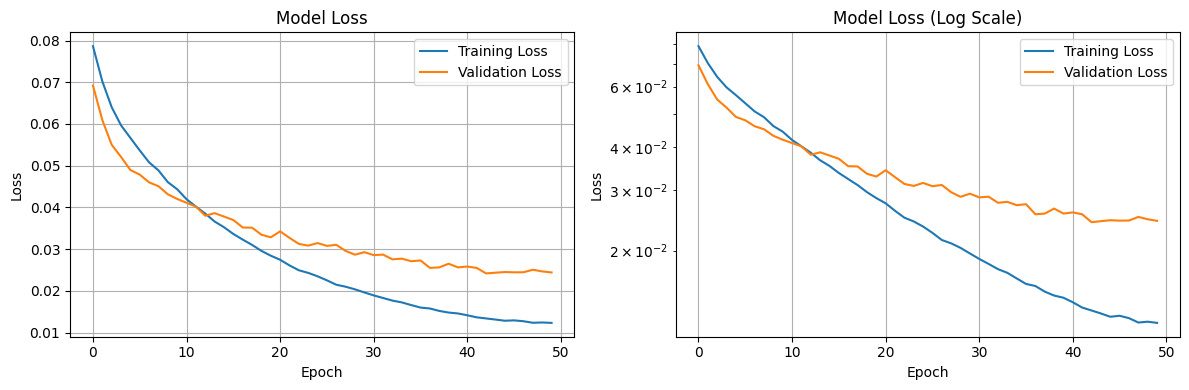

Training logs saved to training_logs.csv


In [11]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation loss"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (Log Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Save training logs
training_logs = {
    'epoch': list(range(1, len(history.history['loss']) + 1)),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss']
}

logs_df = pd.DataFrame(training_logs)
logs_df.to_csv(os.path.join(MODEL_DIR, 'training_logs.csv'), index=False)
print("Training logs saved to training_logs.csv")


In [12]:
# Model evaluation functions
def evaluate_model_performance(model, identity_groups, threshold=0.5, num_batches=20):
    """Evaluate model performance and return predictions and labels"""
    test_generator = batch_generator(identity_groups, BATCH_SIZE, augment=False)
    
    all_predictions = []
    all_labels = []
    
    print(f"Evaluating model with {num_batches} batches...")
    
    for batch_idx in range(num_batches):
        try:
            [left_batch, right_batch], labels_batch = next(test_generator)
            predictions = model.predict([left_batch, right_batch], verbose=0)
            
            all_predictions.extend(predictions.flatten())
            all_labels.extend(labels_batch)
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            break
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate binary predictions using threshold
    binary_predictions = (all_predictions < threshold).astype(int)
    
    return all_predictions, all_labels, binary_predictions

def find_optimal_threshold(predictions, labels):
    """Find optimal threshold for classification"""
    thresholds = np.arange(0.1, 2.0, 0.05)
    best_accuracy = 0
    best_threshold = 0.5
    
    accuracies = []
    
    for threshold in thresholds:
        binary_preds = (predictions < threshold).astype(int)
        accuracy = np.mean(binary_preds == labels)
        accuracies.append(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    return best_threshold, best_accuracy, thresholds, accuracies

print("Evaluation functions defined successfully!")


Evaluation functions defined successfully!


Evaluating on validation set...
Evaluating model with 15 batches...
\nValidation Results:
Best threshold: 0.5500
Best validation accuracy: 0.8500


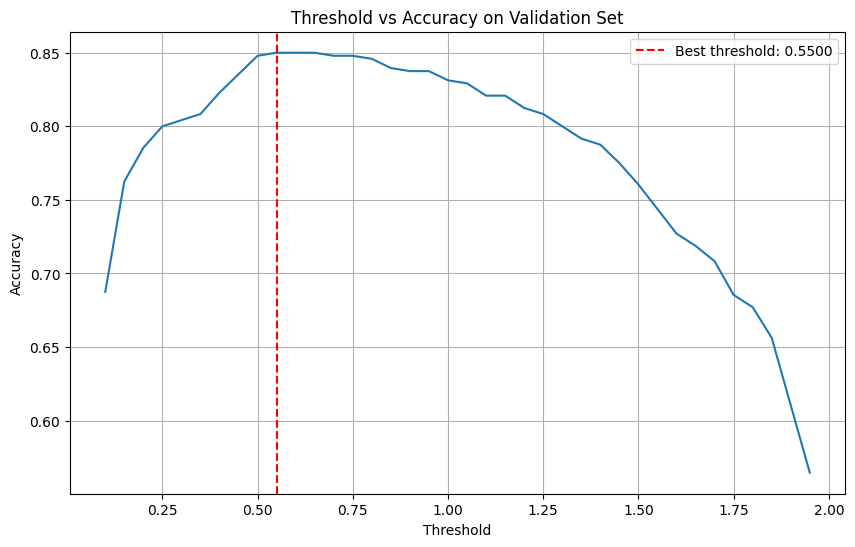

Best threshold saved: 0.5500000000000002


In [13]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_predictions, val_labels, _ = evaluate_model_performance(siamese_model, val_identities, num_batches=15)

# Find optimal threshold
best_threshold, best_val_accuracy, thresholds, accuracies = find_optimal_threshold(val_predictions, val_labels)

print(f"\\nValidation Results:")
print(f"Best threshold: {best_threshold:.4f}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies)
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold: {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold vs Accuracy on Validation Set')
plt.legend()
plt.grid(True)
plt.show()

# Save best threshold
with open(os.path.join(MODEL_DIR, 'best_threshold.txt'), 'w') as f:
    f.write(str(best_threshold))
print(f"Best threshold saved: {best_threshold}")


In [14]:
# Evaluate on test set
print("Evaluating on test set...")
test_predictions, test_labels, test_binary_predictions = evaluate_model_performance(
    siamese_model, test_identities, threshold=best_threshold, num_batches=20
)

# Calculate final metrics
test_accuracy = np.mean(test_binary_predictions == test_labels)
print(f"\\nTest Results:")
print(f"Test accuracy: {test_accuracy:.4f}")

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_labels, test_binary_predictions)
recall = recall_score(test_labels, test_binary_predictions)
f1 = f1_score(test_labels, test_binary_predictions)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Classification report
print("\\nClassification Report:")
print(classification_report(test_labels, test_binary_predictions, 
                          target_names=['Different Identity', 'Same Identity']))


Evaluating on test set...
Evaluating model with 20 batches...
\nTest Results:
Test accuracy: 0.8438
Precision: 0.7926
Recall: 0.9313
F1-score: 0.8563
\nClassification Report:
                    precision    recall  f1-score   support

Different Identity       0.92      0.76      0.83       320
     Same Identity       0.79      0.93      0.86       320

          accuracy                           0.84       640
         macro avg       0.85      0.84      0.84       640
      weighted avg       0.85      0.84      0.84       640



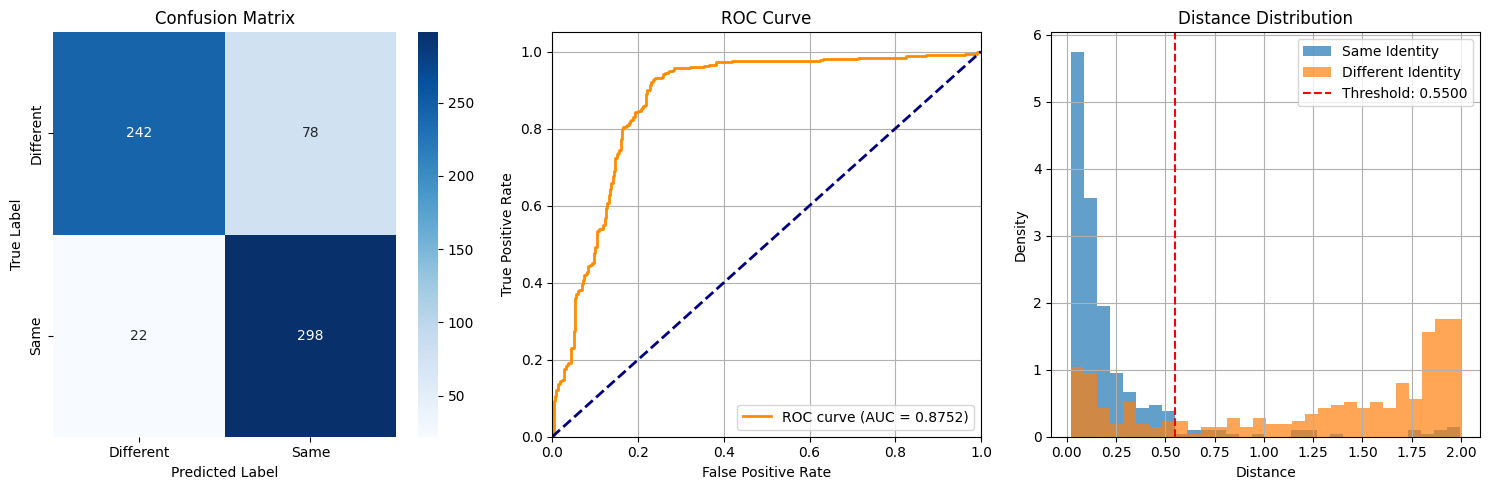

ROC AUC Score: 0.8752


In [15]:
# Confusion Matrix and ROC Curve Analysis
def plot_confusion_matrix_and_roc(y_true, y_pred_binary, y_pred_proba):
    """Plot confusion matrix and ROC curve"""
    plt.figure(figsize=(15, 5))
    
    # Confusion Matrix
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Different', 'Same'], 
                yticklabels=['Different', 'Same'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # ROC Curve
    plt.subplot(1, 3, 2)
    # Convert distances to similarity scores for ROC (lower distance = higher similarity)
    similarity_scores = 1 / (1 + y_pred_proba)  # Convert distance to similarity
    fpr, tpr, roc_thresholds = roc_curve(y_true, similarity_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Distance Distribution
    plt.subplot(1, 3, 3)
    same_distances = y_pred_proba[y_true == 1]
    diff_distances = y_pred_proba[y_true == 0]
    
    plt.hist(same_distances, alpha=0.7, label='Same Identity', bins=30, density=True)
    plt.hist(diff_distances, alpha=0.7, label='Different Identity', bins=30, density=True)
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Threshold: {best_threshold:.4f}')
    plt.xlabel('Distance')
    plt.ylabel('Density')
    plt.title('Distance Distribution')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc

# Generate comprehensive evaluation plots
roc_auc_score = plot_confusion_matrix_and_roc(test_labels, test_binary_predictions, test_predictions)
print(f"ROC AUC Score: {roc_auc_score:.4f}")


In [16]:
# Final model saving and summary
timestamp = int(time.time())
final_siamese_path = os.path.join(MODEL_DIR, f'final_siamese_model_{timestamp}.h5')
final_base_path = os.path.join(MODEL_DIR, f'final_base_model_{timestamp}.h5')

siamese_model.save(final_siamese_path)
base_network.save(final_base_path)

print("Final models saved successfully!")
print(f"Siamese model: {final_siamese_path}")
print(f"Base model: {final_base_path}")

# Create final results summary
results_summary = {
    'Training Summary': {
        'Total Epochs': len(history.history['loss']),
        'Final Training Loss': history.history['loss'][-1],
        'Final Validation Loss': history.history['val_loss'][-1],
        'Training Time (hours)': training_time / 3600
    },
    'Model Performance': {
        'Best Threshold': best_threshold,
        'Validation Accuracy': best_val_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc_score
    },
    'Dataset Statistics': {
        'Training Samples': len(train_df),
        'Validation Samples': len(val_df),
        'Test Samples': len(test_df),
        'Training Identity Groups': len(train_identities),
        'Validation Identity Groups': len(val_identities),
        'Test Identity Groups': len(test_identities)
    }
}

# Save results summary
import json
with open(os.path.join(MODEL_DIR, 'results_summary.json'), 'w') as f:
    json.dump(results_summary, f, indent=2)

print("\\n" + "="*60)
print("TRAINING COMPLETE - RESULTS SUMMARY")
print("="*60)
for category, metrics in results_summary.items():
    print(f"\\n{category}:")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.6f}")
        else:
            print(f"  {key}: {value}")


Final models saved successfully!
Siamese model: ./models\final_siamese_model_1750872712.h5
Base model: ./models\final_base_model_1750872712.h5
\n============================================================
TRAINING COMPLETE - RESULTS SUMMARY
\nTraining Summary:
  Total Epochs: 50
  Final Training Loss: 0.012319
  Final Validation Loss: 0.024410
  Training Time (hours): 11.823336
\nModel Performance:
  Best Threshold: 0.550000
  Validation Accuracy: 0.850000
  Test Accuracy: 0.843750
  Precision: 0.792553
  Recall: 0.931250
  F1-Score: 0.856322
  ROC AUC: 0.875225
\nDataset Statistics:
  Training Samples: 4405
  Validation Samples: 1480
  Test Samples: 1464
  Training Identity Groups: 1470
  Validation Identity Groups: 486
  Test Identity Groups: 479


In [17]:
# Example inference function
def predict_similarity(model, img_path1, img_path2, threshold):
    """Predict similarity between two images"""
    img1 = load_and_preprocess_image(img_path1)
    img2 = load_and_preprocess_image(img_path2)
    
    if img1 is None or img2 is None:
        return None, None
    
    # Add batch dimension
    img1 = np.expand_dims(img1, axis=0)
    img2 = np.expand_dims(img2, axis=0)
    
    # Get distance prediction
    distance = model.predict([img1, img2], verbose=0)[0][0]
    
    # Convert to binary prediction
    is_same = distance < threshold
    confidence = 1 / (1 + distance)  # Convert distance to confidence score
    
    return is_same, confidence, distance

# Test with a few sample pairs
def test_sample_pairs(model, identity_groups, threshold, num_samples=3):
    """Test the model with sample pairs"""
    all_identities = list(identity_groups.keys())
    valid_identities = [identity for identity in all_identities 
                       if len(identity_groups[identity]) >= 2]
    
    print("Sample Predictions:")
    print("-" * 60)
    
    for i in range(num_samples):
        # Test positive pair (same identity)
        identity = random.choice(valid_identities)
        images = identity_groups[identity]
        img1, img2 = random.sample(images, 2)
        
        is_same, confidence, distance = predict_similarity(model, img1, img2, threshold)
        result = "✓ CORRECT" if is_same else "✗ INCORRECT"
        print(f"Same Identity Test {i+1}: {result}")
        print(f"  Distance: {distance:.4f}, Confidence: {confidence:.4f}")
        print(f"  Images: {os.path.basename(img1)} & {os.path.basename(img2)}")
        
        # Test negative pair (different identity)
        identity1, identity2 = random.sample(valid_identities, 2)
        img1 = random.choice(identity_groups[identity1])
        img2 = random.choice(identity_groups[identity2])
        
        is_same, confidence, distance = predict_similarity(model, img1, img2, threshold)
        result = "✓ CORRECT" if not is_same else "✗ INCORRECT"
        print(f"Different Identity Test {i+1}: {result}")
        print(f"  Distance: {distance:.4f}, Confidence: {confidence:.4f}")
        print(f"  Images: {os.path.basename(img1)} & {os.path.basename(img2)}")
        print("-" * 60)

# Run sample tests
test_sample_pairs(siamese_model, test_identities, best_threshold, num_samples=3)


Sample Predictions:
------------------------------------------------------------
Same Identity Test 1: ✓ CORRECT
  Distance: 0.0272, Confidence: 0.9735
  Images: British_Shorthair_267.jpg & British_Shorthair_177.jpg
Different Identity Test 1: ✗ INCORRECT
  Distance: 0.4910, Confidence: 0.6707
  Images: american_pit_bull_terrier_181.jpg & miniature_pinscher_159.jpg
------------------------------------------------------------
Same Identity Test 2: ✓ CORRECT
  Distance: 0.0870, Confidence: 0.9200
  Images: Bengal_159.jpg & Bengal_94.jpg
Different Identity Test 2: ✓ CORRECT
  Distance: 1.6014, Confidence: 0.3844
  Images: keeshond_194.jpg & Persian_116.jpg
------------------------------------------------------------
Same Identity Test 3: ✓ CORRECT
  Distance: 0.2532, Confidence: 0.7980
  Images: miniature_pinscher_114.jpg & miniature_pinscher_51.jpg
Different Identity Test 3: ✓ CORRECT
  Distance: 1.6341, Confidence: 0.3796
  Images: keeshond_11.jpg & boxer_164.jpg
------------------------